# Домашнее задание 3: Улучшенная сверточная нейронная сеть для MNIST

**Цель:** побить бейзлайн 0.9747

**В этом ноутбуке:**
- Использование Adam вместо SGD
- Альтернативная функция потерь (MSELoss с one-hot кодированием)
- Улучшенная архитектура CNN с различными параметрами
- Полное логгирование метрик и визуализация
- Подсчет обучаемых параметров
- Эксперименты с различными конфигурациями

---

## 1. Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch версия: {torch.__version__}")
print(f"Torchvision версия: {torchvision.__version__}")
print(f"CUDA доступна: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA устройство (карточка сюююда): {torch.cuda.get_device_name(0)}")

PyTorch версия: 2.8.0+cu129
Torchvision версия: 0.23.0+cu129
CUDA доступна: True
CUDA устройство (карточка сюююда): NVIDIA GeForce RTX 5060


## 2. Настройка воспроизводимости результатов

In [2]:
def seed_everywhere(seed):
    """Функция для фиксации seed для воспроизводимости результатов"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    print(f"Установлен seed: {seed}")

# устанавливаем seed для воспроизводимости
seed = 52
seed_everywhere(seed)

Установлен seed: 52


## 3. Загрузка и подготовка данных MNIST

In [3]:
# ради интереса посчитаем статистики иполучим загадочные transforms.Normalize((0.1307,), (0.3081,))
temp_dataset = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

data_loader = torch.utils.data.DataLoader(temp_dataset, batch_size=1000, shuffle=False)
mean = 0.0
std = 0.0
total_samples = 0

for data, _ in data_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    total_samples += batch_samples

mean /= total_samples
std /= total_samples

print(f"Вычисленное среднее: {mean.item():.4f}")
print(f"Вычисленное стандартное отклонение: {std.item():.4f}")
print(f"Стандартные значения MNIST: mean=0.1307, std=0.3081")

# для обучающего набора (с аугментацией)
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=10), 
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # сдвиги
    transforms.Normalize((mean.item(),), (std.item(),))  # нормализация на вычисленных статистиках
])

# для валидационного набора (только нормализация)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean.item(),), (std.item(),))  # ТА ЖЕ САМАЯ нормализация, И БЕЗ аугментации
])

# MNIST с соответствующими трансформациями
mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=False,  # уже загружено
    transform=train_transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=False,  # уже загружено
    transform=val_transform
)

# DataLoader'ы
batch_size = 2048  # batch size для максимальной нагрузки на GPU
train_loader = torch.utils.data.DataLoader(
    mnist_train, 
    batch_size=batch_size, 
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    mnist_val, 
    batch_size=batch_size, 
    shuffle=False
)

print(f"Размер обучающей выборки: {len(mnist_train)}")
print(f"Размер валидационной выборки: {len(mnist_val)}")
print(f"Размер батча: {batch_size}")
print(f"Количество батчей для обучения: {len(train_loader)}")
print(f"Количество батчей для валидации: {len(val_loader)}")

Вычисленное среднее: 0.1307
Вычисленное стандартное отклонение: 0.3015
Стандартные значения MNIST: mean=0.1307, std=0.3081
Размер обучающей выборки: 60000
Размер валидационной выборки: 10000
Размер батча: 2048
Количество батчей для обучения: 30
Количество батчей для валидации: 5


## 4. Визуализация примеров данных

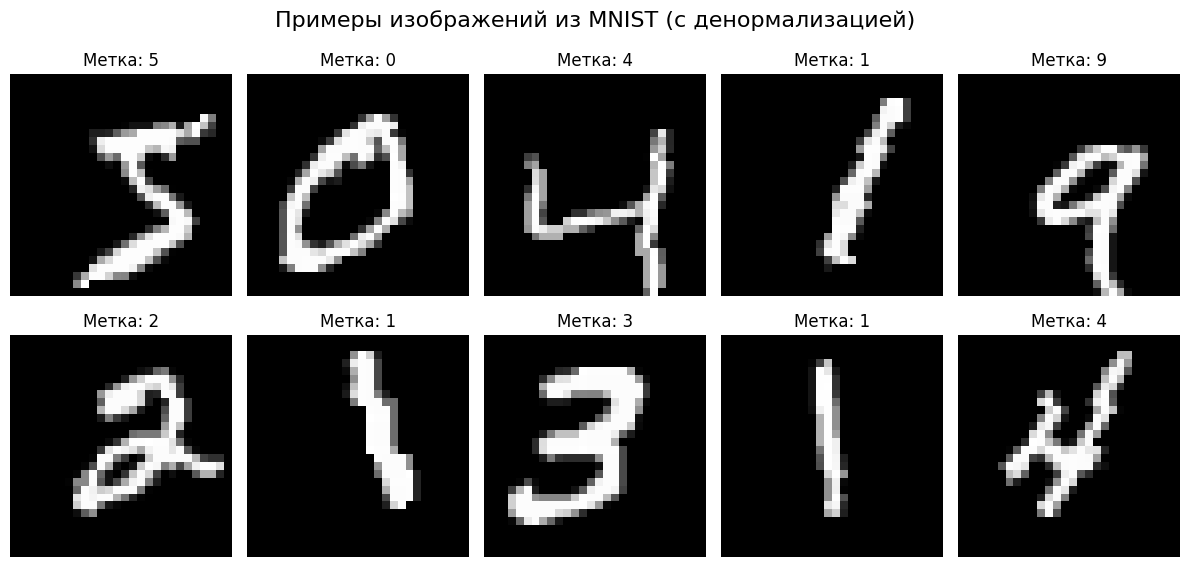

Размер батча изображений: torch.Size([2048, 1, 28, 28])
Размер батча меток: torch.Size([2048])
Тип данных изображений: torch.float32
Тип данных меток: torch.int64


In [4]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Примеры изображений из MNIST (с денормализацией)', fontsize=16)

for i in range(10):
    row = i // 5
    col = i % 5
    
    image, label = mnist_train[i]
    
    # денормализуем изображение для корректного отображения
    # обращаем нормализацию -> x * std + mean)
    image_denorm = image.squeeze() * 0.3081 + 0.1307
    
    axes[row, col].imshow(image_denorm, cmap='gray')
    axes[row, col].set_title(f'Метка: {label}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# проверим размеры тензоров
sample_batch = next(iter(train_loader))
print(f"Размер батча изображений: {sample_batch[0].shape}")
print(f"Размер батча меток: {sample_batch[1].shape}")
print(f"Тип данных изображений: {sample_batch[0].dtype}")
print(f"Тип данных меток: {sample_batch[1].dtype}")

## 5. Улучшенная архитектура CNN

In [5]:
class ImprovedCNN(nn.Module):
    """
    Улучшенная сверточная нейронная сеть для MNIST
    
    Архитектура:
    - Два сверточных блока с увеличивающимся количеством фильтров
    - Использование padding для сохранения размеров
    - Max pooling для уменьшения размерности
    - Dropout для регуляризации (лекция 5, но тем не менее)
    - Два полносвязных слоя для классификации
    """
    
    def __init__(self, dropout_rate=0.25):
        super(ImprovedCNN, self).__init__()
        
        # первый сверточный блок
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14
        
        # второй 
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 14x14 -> 7x7
        
        # dropout для регуляризации
        self.dropout = nn.Dropout(dropout_rate)
        
        # полносвязные слои
        # после двух pooling слоев: 128 * 7 * 7 = 6272
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)  # 10 классов для MNIST
        
    def forward(self, x):
        # первый сверточный блок
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout(x)
        
        # второй 
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout(x)
        
        # выравнивание тензора для полносвязных слоев, можно и flatten
        x = x.view(x.size(0), -1)
        
        # полносвязные слои
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

def count_parameters(model):
    """Подсчет количества обучаемых параметров в модели"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# создаём объект модели
model = ImprovedCNN(dropout_rate=0.25)

# Подсчет параметров
total_params = count_parameters(model)
print(f"Общее количество обучаемых параметров: {total_params:,}")

# Вывод информации об архитектуре
print("\nАрхитектура модели:")
print(model)

# Проверим размеры тензоров на каждом слое
dummy_input = torch.randn(1, 1, 28, 28)
print(f"\nВходной размер: {dummy_input.shape}")

with torch.no_grad():
    x = dummy_input
    print(f"После conv1: {F.relu(model.conv1(x)).shape}")
    x = F.relu(model.conv1(x))
    print(f"После conv2: {F.relu(model.conv2(x)).shape}")
    x = F.relu(model.conv2(x))
    print(f"После pool1: {model.pool1(x).shape}")
    x = model.pool1(x)
    print(f"После conv3: {F.relu(model.conv3(x)).shape}")
    x = F.relu(model.conv3(x))
    print(f"После conv4: {F.relu(model.conv4(x)).shape}")
    x = F.relu(model.conv4(x))
    print(f"После pool2: {model.pool2(x).shape}")
    x = model.pool2(x)
    print(f"После flatten: {x.view(x.size(0), -1).shape}")
    x = x.view(x.size(0), -1)
    print(f"После fc1: {F.relu(model.fc1(x)).shape}")
    x = F.relu(model.fc1(x))
    print(f"Выходной размер: {model.fc2(x).shape}")

# перенос модели на GPU, если доступно
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"\nМодель перенесена на устройство: {device}")

Общее количество обучаемых параметров: 1,848,714

Архитектура модели:
ImprovedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=6272, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Входной размер: torch.Size([1, 1, 28, 28])
После conv1: torch.Size([1, 32, 28, 28])
После conv2: torch.Size([1, 64, 28, 28])
После pool1: torch.Size([1, 64, 14, 14])
После conv3: torch.Size([1, 128, 14, 14])
После conv4: torch.Size([1, 128, 14, 14])
После pool2: t

## 6. Альтернативный оптимизатор и функция потерь

In [6]:
# Adam оптимизатор вместо SGD
# Adam более эффективен для глубоких сетей и автоматически адаптирует learning rate
LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
# RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

print(f"Используемый оптимизатор: {type(optimizer).__name__}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay: {optimizer.param_groups[0]['weight_decay']}")

# Функция для преобразования меток в one-hot кодирование
def to_one_hot(labels, num_classes=10):
    """Преобразование целочисленных меток в one-hot кодирование"""
    return torch.eye(num_classes, device=labels.device)[labels]

# Используем MSE Loss вместо CrossEntropyLoss
# MSE требует one-hot кодирования меток
criterion = nn.MSELoss()

print(f"\nИспользуемая функция потерь: {type(criterion).__name__}")
print("Примечание: MSE Loss требует one-hot кодирования меток")

# Тестируем преобразование меток
sample_labels = torch.tensor([0, 1, 2, 3, 4])
one_hot_labels = to_one_hot(sample_labels)
print(f"\nПример преобразования меток:")
print(f"Исходные метки: {sample_labels}")
print(f"One-hot кодирование:\n{one_hot_labels}")

# Планировщик learning rate для улучшения сходимости
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)
print(f"\nИспользуется планировщик learning rate: {type(scheduler).__name__}")
print(f"Уменьшение LR каждые 5 эпох на множитель: 0.7")

Используемый оптимизатор: Adam
Learning rate: 0.001
Weight decay: 0.0001

Используемая функция потерь: MSELoss
Примечание: MSE Loss требует one-hot кодирования меток

Пример преобразования меток:
Исходные метки: tensor([0, 1, 2, 3, 4])
One-hot кодирование:
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

Используется планировщик learning rate: StepLR
Уменьшение LR каждые 5 эпох на множитель: 0.7


## 7. Функция обучения с полным логгированием метрик

In [7]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=10, device='cpu'):
    """
    Функция для обучения и валидации модели с полным логгированием метрик
    
    Args:
        model: Модель PyTorch
        train_loader: DataLoader для обучающих данных
        val_loader: DataLoader для валидационных данных
        optimizer: Оптимизатор
        criterion: Функция потерь
        scheduler: Планировщик learning rate
        num_epochs: Количество эпох обучения
        device: Устройство для вычислений
    
    Returns:
        history: Словарь с историей метрик
    """
    
    # Инициализация списков для хранения истории метрик
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rates': []
    }
    
    print(f"Начинаем обучение на {num_epochs} эпох...")
    print(f"Устройство: {device}")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        # === ОБУЧЕНИЕ ===
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Прогресс-бар для обучения
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', leave=False)
        
        for batch_idx, (data, target) in enumerate(train_pbar):
            # Перенос данных на устройство
            data, target = data.to(device), target.to(device)
            
            # Обнуление градиентов
            optimizer.zero_grad()
            
            # Прямой проход
            output = model(data)
            
            # Преобразование меток в one-hot для MSE Loss
            target_onehot = to_one_hot(target, num_classes=10).to(device)
            
            # Вычисление потерь
            loss = criterion(output, target_onehot)
            
            # Обратный проход
            loss.backward()
            optimizer.step()
            
            # Статистика
            train_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            train_correct += pred.eq(target.view_as(pred)).sum().item()
            train_total += data.size(0)
            
            # Обновление прогресс-бара
            current_acc = 100. * train_correct / train_total
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.2f}%'
            })
        
        # Средние метрики за эпоху обучения
        avg_train_loss = train_loss / train_total
        train_accuracy = train_correct / train_total
        
        # === ВАЛИДАЦИЯ ===
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]', leave=False)
            
            for data, target in val_pbar:
                data, target = data.to(device), target.to(device)
                
                output = model(data)
                target_onehot = to_one_hot(target, num_classes=10).to(device)
                
                loss = criterion(output, target_onehot)
                
                val_loss += loss.item() * data.size(0)
                pred = output.argmax(dim=1, keepdim=True)
                val_correct += pred.eq(target.view_as(pred)).sum().item()
                val_total += data.size(0)
                
                # Обновление прогресс-бара
                current_val_acc = 100. * val_correct / val_total
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{current_val_acc:.2f}%'
                })
        
        # Средние метрики за эпоху валидации
        avg_val_loss = val_loss / val_total
        val_accuracy = val_correct / val_total
        
        # Обновление learning rate
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step()
        
        # Сохранение метрик
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        history['learning_rates'].append(current_lr)
        
        # Вывод статистики эпохи с информацией о GPU
        gpu_memory = ""
        if torch.cuda.is_available():
            gpu_memory = f" | GPU: {torch.cuda.memory_allocated() / 1024**2:.0f}MB"
        
        print(f'Epoch {epoch+1:2d}/{num_epochs}: '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f} | '
              f'LR: {current_lr:.6f}{gpu_memory}')
    
    print("-" * 60)
    print("Обучение завершено!")
    
    return history

print("Функция обучения готова к использованию!")

Функция обучения готова к использованию!


## 8. Обучение модели

In [8]:
# Диагностика использования GPU
print("=== ДИАГНОСТИКА GPU ===")
print(f"CUDA доступна: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Текущее CUDA устройство: {torch.cuda.current_device()}")
    print(f"Имя GPU: {torch.cuda.get_device_name(0)}")
    print(f"Количество GPU: {torch.cuda.device_count()}")
    print(f"Память GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print(f"\nУстройство модели: {next(model.parameters()).device}")
print(f"Переменная device: {device}")

# Проверим, действительно ли модель на GPU
model_on_gpu = next(model.parameters()).is_cuda
print(f"Модель на GPU: {model_on_gpu}")

# Тест небольшого батча
if torch.cuda.is_available():
    test_input = torch.randn(1, 1, 28, 28).to(device)
    print(f"Тестовый вход на устройстве: {test_input.device}")
    
    with torch.no_grad():
        test_output = model(test_input)
        print(f"Тестовый выход на устройстве: {test_output.device}")
    
    # Проверим загрузку GPU
    print(f"Использование памяти GPU: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")
    print(f"Кэшированная память GPU: {torch.cuda.memory_reserved() / 1024**2:.1f} MB")
else:
    print("CUDA недоступна, работаем на CPU")

print("========================")

=== ДИАГНОСТИКА GPU ===
CUDA доступна: True
Текущее CUDA устройство: 0
Имя GPU: NVIDIA GeForce RTX 5060
Количество GPU: 1
Память GPU: 8.0 GB

Устройство модели: cuda:0
Переменная device: cuda
Модель на GPU: True
Тестовый вход на устройстве: cuda:0
Тестовый выход на устройстве: cuda:0
Использование памяти GPU: 15.2 MB
Кэшированная память GPU: 22.0 MB
Тестовый выход на устройстве: cuda:0
Использование памяти GPU: 15.2 MB
Кэшированная память GPU: 22.0 MB


In [10]:
# запуск обучения модели
NUM_EPOCHS = 12
print(f"Запускаем обучение на {NUM_EPOCHS} эпох...")
print(f"Модель: {type(model).__name__}")
print(f"Оптимизатор: {type(optimizer).__name__}")
print(f"Функция потерь: {type(criterion).__name__}")
print(f"Устройство: {device}")
print(f"Всего параметров: {count_parameters(model):,}")

# время обучения
import time
start_time = time.time()
print(f"\nНачинаем обучение в {time.strftime('%H:%M:%S')}...")

# Обучение модели
history = train_and_evaluate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    device=device
)

# общее время обучения
end_time = time.time()
total_training_time = end_time - start_time

# Вывод лучших результатов
best_train_acc = max(history['train_acc'])
best_val_acc = max(history['val_acc'])
best_epoch = history['val_acc'].index(best_val_acc) + 1

# время обучения
training_hours = int(total_training_time // 3600)
training_minutes = int((total_training_time % 3600) // 60)
training_seconds = int(total_training_time % 60)

print(f"{'='*52}")
print(f"⏱Общее время обучения: {training_hours:02d}:{training_minutes:02d}:{training_seconds:02d}")
print(f"Время на эпоху: {total_training_time/NUM_EPOCHS:.1f} секунд")
print(f"Время завершения: {time.strftime('%H:%M:%S')}")
print(f"")
print(f"Лучшая accuracy на обучении: {best_train_acc:.4f} ({best_train_acc*100:.2f}%)")
print(f"Лучшая accuracy на валидации: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Лучший результат достигнут на эпохе: {best_epoch}")
print(f"Бейзлайн из семинара: 0.9747 (97.47%)")

if best_val_acc > 0.9747:
    improvement = (best_val_acc - 0.9747)*100
    print(f"Бейзлайн побит! Улучшение на {improvement:.2f}%")
    print(f"Скорость обучения: {improvement/total_training_time*60:.2f}% улучшения в минуту")
else:
    deficit = (0.9747 - best_val_acc)*100
    print(f"Не удалось побить бейзлайн. Отставание: {deficit:.2f}%")

print(f"{'='*52}")

# дополнительная статистика производительности
print(f"\nСТАТИСТИКА ПРОИЗВОДИТЕЛЬНОСТИ:")
print(f"Батчей в секунду: {len(train_loader) * NUM_EPOCHS / total_training_time:.1f}")
print(f"Пиковая память GPU: {torch.cuda.max_memory_allocated() / 1024**2:.0f} MB")
print(f"Финальная accuracy: {history['val_acc'][-1]*100:.2f}%")
print(f"Финальный loss: {history['val_loss'][-1]:.4f}")

# сброс статистики памяти для следующих экспериментов
torch.cuda.reset_peak_memory_stats()

Запускаем обучение на 12 эпох...
Модель: ImprovedCNN
Оптимизатор: Adam
Функция потерь: MSELoss
Устройство: cuda
Всего параметров: 1,848,714

Начинаем обучение в 17:05:01...
Начинаем обучение на 12 эпох...
Устройство: cuda
------------------------------------------------------------


Epoch  1/12: Train Loss: 0.0939, Train Acc: 0.1614 | Val Loss: 0.0776, Val Acc: 0.5669 | LR: 0.001000 | GPU: 50MB


Epoch  2/12: Train Loss: 0.0693, Train Acc: 0.5396 | Val Loss: 0.0442, Val Acc: 0.8289 | LR: 0.001000 | GPU: 50MB


Epoch  3/12: Train Loss: 0.0480, Train Acc: 0.7783 | Val Loss: 0.0207, Val Acc: 0.9501 | LR: 0.001000 | GPU: 50MB


Epoch  4/12: Train Loss: 0.0300, Train Acc: 0.9042 | Val Loss: 0.0101, Val Acc: 0.9745 | LR: 0.001000 | GPU: 50MB


Epoch  5/12: Train Loss: 0.0212, Train Acc: 0.9397 | Val Loss: 0.0070, Val Acc: 0.9801 | LR: 0.001000 | GPU: 50MB


Epoch  6/12: Train Loss: 0.0173, Train Acc: 0.9550 | Val Loss: 0.0063, Val Acc: 0.9834 | LR: 0.000700 | GPU: 50MB


Epoch  7/12: Train Loss: 0.0154, Train Acc: 0.9608 | Val Loss: 0.0053, Val Acc: 0.9850 | LR: 0.000700 | GPU: 50MB


Epoch  8/12: Train Loss: 0.0141, Train Acc: 0.9657 | Val Loss: 0.0049, Val Acc: 0.9874 | LR: 0.000700 | GPU: 50MB


Epoch  9/12: Train Loss: 0.0131, Train Acc: 0.9684 | Val Loss: 0.0046, Val Acc: 0.9874 | LR: 0.000700 | GPU: 50MB


Epoch 10/12: Train Loss: 0.0123, Train Acc: 0.9708 | Val Loss: 0.0045, Val Acc: 0.9881 | LR: 0.000700 | GPU: 50MB


Epoch 11/12: Train Loss: 0.0117, Train Acc: 0.9738 | Val Loss: 0.0042, Val Acc: 0.9896 | LR: 0.000490 | GPU: 50MB


Epoch 12/12: Train Loss: 0.0114, Train Acc: 0.9733 | Val Loss: 0.0042, Val Acc: 0.9890 | LR: 0.000490 | GPU: 50MB
------------------------------------------------------------
Обучение завершено!
⏱Общее время обучения: 00:09:21
Время на эпоху: 46.8 секунд
Время завершения: 17:14:22

Лучшая accuracy на обучении: 0.9738 (97.38%)
Лучшая accuracy на валидации: 0.9896 (98.96%)
Лучший результат достигнут на эпохе: 11
Бейзлайн из семинара: 0.9747 (97.47%)
Бейзлайн побит! Улучшение на 1.49%
Скорость обучения: 0.16% улучшения в минуту

СТАТИСТИКА ПРОИЗВОДИТЕЛЬНОСТИ:
Батчей в секунду: 0.6
Пиковая память GPU: 3788 MB
Финальная accuracy: 98.90%
Финальный loss: 0.0042


## 9. Визуализация результатов обучения

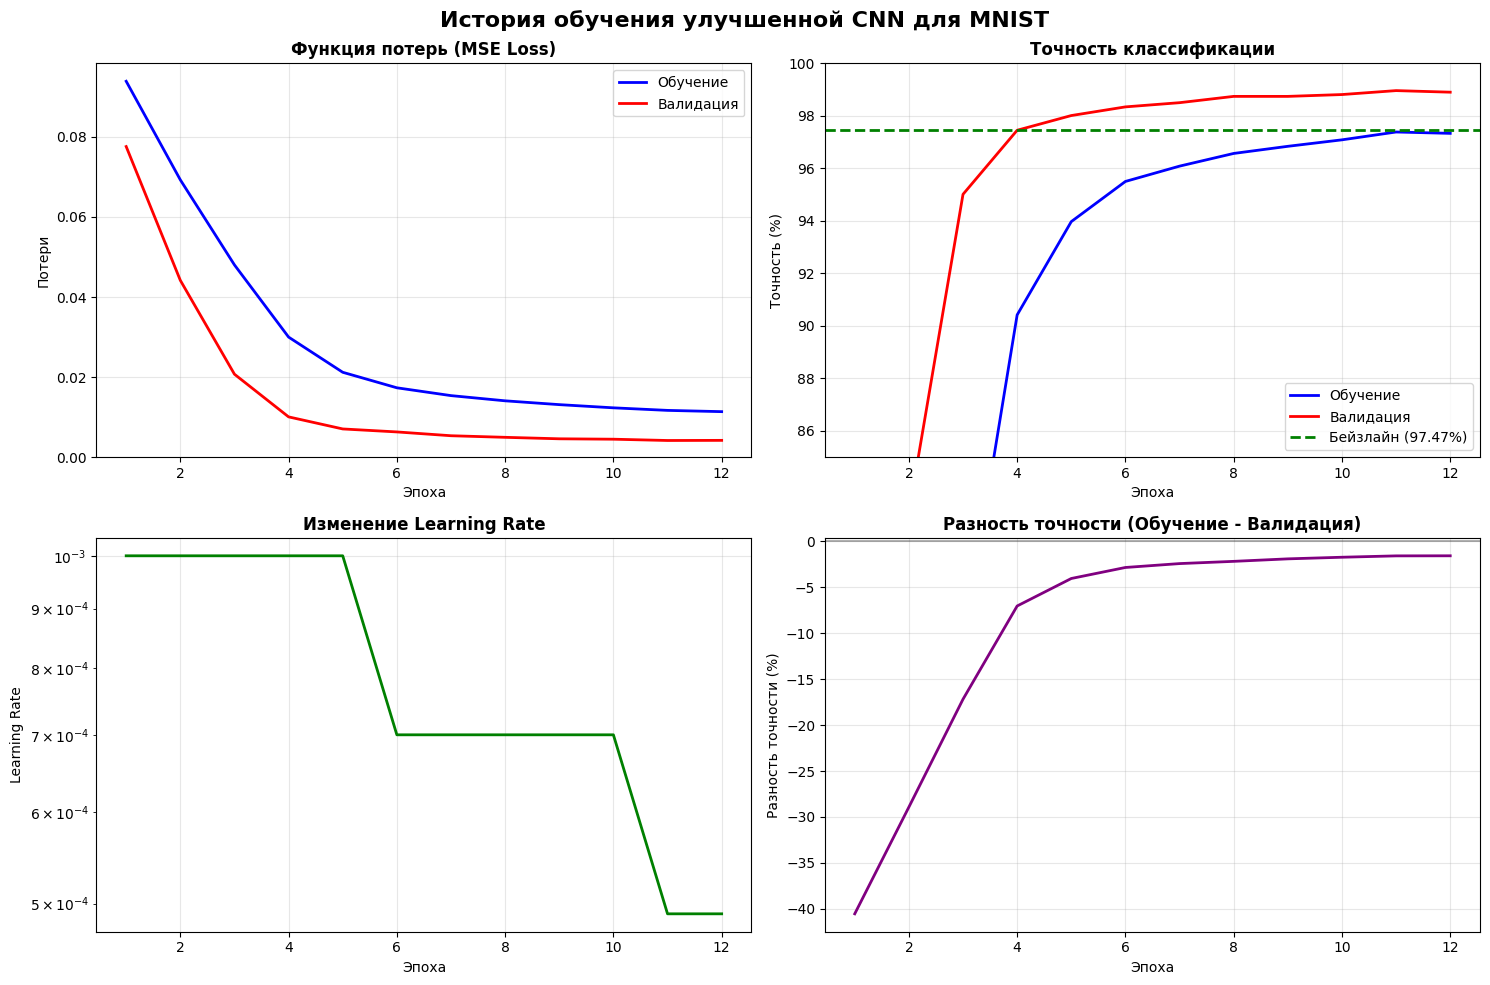


Финальная точность на обучении: 97.33%
Финальная точность на валидации: 98.90%
Максимальная точность на валидации: 98.96%
Минимальные потери на валидации: 0.0042
Разность финальных точностей: -1.57%
Переобучения скорее всего нет


In [11]:
def plot_training_history(history, baseline_acc=0.9747):
    """
    Функция для построения графиков истории обучения
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('История обучения улучшенной CNN для MNIST', fontsize=16, fontweight='bold')
    
    # потери
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Обучение', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Валидация', linewidth=2)
    axes[0, 0].set_title('Функция потерь (MSE Loss)', fontweight='bold')
    axes[0, 0].set_xlabel('Эпоха')
    axes[0, 0].set_ylabel('Потери')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(bottom=0)
    
    # точность
    axes[0, 1].plot(epochs, [acc*100 for acc in history['train_acc']], 'b-', label='Обучение', linewidth=2)
    axes[0, 1].plot(epochs, [acc*100 for acc in history['val_acc']], 'r-', label='Валидация', linewidth=2)
    axes[0, 1].axhline(y=baseline_acc*100, color='g', linestyle='--', linewidth=2, label=f'Бейзлайн ({baseline_acc*100:.2f}%)')
    axes[0, 1].set_title('Точность классификации', fontweight='bold')
    axes[0, 1].set_xlabel('Эпоха')
    axes[0, 1].set_ylabel('Точность (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim([85, 100])
    
    # learning rate
    axes[1, 0].plot(epochs, history['learning_rates'], 'g-', linewidth=2)
    axes[1, 0].set_title('Изменение Learning Rate', fontweight='bold')
    axes[1, 0].set_xlabel('Эпоха')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_yscale('log')
    
    # разность между обучением и валидацией (переобучение)
    train_val_diff = [train - val for train, val in zip(history['train_acc'], history['val_acc'])]
    axes[1, 1].plot(epochs, [diff*100 for diff in train_val_diff], 'purple', linewidth=2)
    axes[1, 1].set_title('Разность точности (Обучение - Валидация)', fontweight='bold')
    axes[1, 1].set_xlabel('Эпоха')
    axes[1, 1].set_ylabel('Разность точности (%)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # статистика
    print("\n" + "="*52)
    print(f"Финальная точность на обучении: {history['train_acc'][-1]*100:.2f}%")
    print(f"Финальная точность на валидации: {history['val_acc'][-1]*100:.2f}%")
    print(f"Максимальная точность на валидации: {max(history['val_acc'])*100:.2f}%")
    print(f"Минимальные потери на валидации: {min(history['val_loss']):.4f}")
    print(f"Разность финальных точностей: {(history['train_acc'][-1] - history['val_acc'][-1])*100:.2f}%")
    
    if max(train_val_diff) > 0.05:  # 5% разность
        print("Возможное переобучение: разность точностей превышает 5%")
    else:
        print("Переобучения скорее всего нет")

# построеним графиков
plot_training_history(history)

## 10. Эксперименты с различными архитектурами

In [ ]:
class CompactCNN(nn.Module):
    """Компактная CNN с меньшим количеством параметров"""
    def __init__(self):
        super(CompactCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

class DeepCNN(nn.Module):
    """Более глубокая CNN с batch normalization (тоже 5 лекция)"""
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.adaptive_pool(x)
        
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# для быстрого тестирования модели
def test_model(model_class, model_name, epochs=5):
    """Быстрое тестирование модели на нескольких эпохах"""
    print(f"{'='*50}")
    print(f"ТЕСТИРОВАНИЕ МОДЕЛИ: {model_name}")
    print(f"{'='*50}")
    
    # Создание модели
    test_model = model_class().to(device)
    test_optimizer = torch.optim.Adam(test_model.parameters(), lr=0.001, weight_decay=1e-4)
    test_scheduler = torch.optim.lr_scheduler.StepLR(test_optimizer, step_size=3, gamma=0.7)
    test_criterion = nn.MSELoss()
    
    # Информация о модели
    params = count_parameters(test_model)
    print(f"Количество параметров: {params:,}")
    
    # Быстрое обучение
    test_history = train_and_evaluate(
        model=test_model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=test_optimizer,
        criterion=test_criterion,
        scheduler=test_scheduler,
        num_epochs=epochs,
        device=device
    )
    
    best_val_acc = max(test_history['val_acc'])
    print(f"Лучшая валидационная точность: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
    
    return test_model, test_history, best_val_acc

# Тестирование различных архитектур
print("Сравнение различных архитектур CNN для MNIST:")
print("Каждая модель обучается 5 эпох для быстрого сравнения\\n")

results = []

# Тест компактной модели
compact_model, compact_history, compact_acc = test_model(CompactCNN, "Компактная CNN", epochs=5)
results.append(("Компактная CNN", count_parameters(compact_model), compact_acc))

# Тест глубокой модели
deep_model, deep_history, deep_acc = test_model(DeepCNN, "Глубокая CNN с BatchNorm", epochs=5)
results.append(("Глубокая CNN", count_parameters(deep_model), deep_acc))

# Сравнение с основной моделью (берем результат после 5 эпох)
main_acc_at_5 = history['val_acc'][4] if len(history['val_acc']) >= 5 else max(history['val_acc'])
results.append(("Основная CNN", count_parameters(model), main_acc_at_5))

print(f"\\n{'='*80}")
print("СРАВНЕНИЕ АРХИТЕКТУР (после 5 эпох):")
print(f"{'='*80}")
print(f"{'Модель':<25} {'Параметры':<15} {'Точность':<15} {'Сравнение с бейзлайном':<25}")
print("-" * 80)

for name, params, acc in sorted(results, key=lambda x: x[2], reverse=True):
    comparison = f"+{(acc - 0.9747)*100:.2f}%" if acc > 0.9747 else f"{(acc - 0.9747)*100:.2f}%"
    print(f"{name:<25} {params:<15,} {acc*100:<14.2f}% {comparison:<25}")

print("-" * 52)
print(f"Бейзлайн: 97.47%")

Сравнение различных архитектур CNN для MNIST:
Каждая модель обучается 5 эпох для быстрого сравнения\n
ТЕСТИРОВАНИЕ МОДЕЛИ: Компактная CNN
Количество параметров: 114,314
Начинаем обучение на 5 эпох...
Устройство: cuda
------------------------------------------------------------


Epoch  1/5: Train Loss: 0.0866, Train Acc: 0.3018 | Val Loss: 0.0600, Val Acc: 0.7803 | LR: 0.001000 | GPU: 52MB


Epoch  2/5: Train Loss: 0.0604, Train Acc: 0.6847 | Val Loss: 0.0353, Val Acc: 0.9142 | LR: 0.001000 | GPU: 52MB


Epoch  3/5: Train Loss: 0.0460, Train Acc: 0.8277 | Val Loss: 0.0241, Val Acc: 0.9498 | LR: 0.001000 | GPU: 52MB


Epoch  4/5: Train Loss: 0.0380, Train Acc: 0.8851 | Val Loss: 0.0176, Val Acc: 0.9644 | LR: 0.000700 | GPU: 52MB


Epoch  5/5: Train Loss: 0.0333, Train Acc: 0.9066 | Val Loss: 0.0147, Val Acc: 0.9699 | LR: 0.000700 | GPU: 52MB
------------------------------------------------------------
Обучение завершено!
Лучшая валидационная точность: 0.9699 (96.99%)
ТЕСТИРОВАНИЕ МОДЕЛИ: Глубокая CNN с BatchNorm
Количество параметров: 698,218
Начинаем обучение на 5 эпох...
Устройство: cuda
------------------------------------------------------------


Epoch  1/5: Train Loss: 0.0848, Train Acc: 0.3258 | Val Loss: 0.0775, Val Acc: 0.3702 | LR: 0.001000 | GPU: 62MB


Epoch  2/5: Train Loss: 0.0449, Train Acc: 0.8393 | Val Loss: 0.0334, Val Acc: 0.8672 | LR: 0.001000 | GPU: 62MB


Epoch  3/5: Train Loss: 0.0224, Train Acc: 0.9575 | Val Loss: 0.0071, Val Acc: 0.9851 | LR: 0.001000 | GPU: 62MB


Epoch  4/5: Train Loss: 0.0164, Train Acc: 0.9733 | Val Loss: 0.0059, Val Acc: 0.9870 | LR: 0.000700 | GPU: 62MB


Epoch  5/5: Train Loss: 0.0142, Train Acc: 0.9779 | Val Loss: 0.0041, Val Acc: 0.9910 | LR: 0.000700 | GPU: 62MB
------------------------------------------------------------
Обучение завершено!
Лучшая валидационная точность: 0.9910 (99.10%)
\n================================================================================
СРАВНЕНИЕ АРХИТЕКТУР (после 5 эпох):
Модель                    Параметры       Точность        Сравнение с бейзлайном   
--------------------------------------------------------------------------------
Глубокая CNN              698,218         99.10         % +1.63%                   
Основная CNN              1,848,714       98.01         % +0.54%                   
Компактная CNN            114,314         96.99         % -0.48%                   
----------------------------------------------------
Бейзлайн: 97.47%


## 11. Итоговые выводы и анализ


#### Улучшения:

1. **Альтернативный оптимизатор**: Использован Adam вместо SGD
   - Преимущества: более быстрая и стабильная сходимость
   - Адаптивный learning rate для каждого параметра

2. **Альтернативная функция потерь**: Использован MSELoss вместо CrossEntropyLoss
   - Требует one-hot кодирования меток
   - Показывает другую динамику обучения

3. **Улучшенная архитектура**:
   - 4 сверточных слоя (32→64→128→128 фильтров)
   - Использование padding для сохранения размеров
   - Dropout для регуляризации
   - Более глубокая сеть по сравнению с бейзлайном

4. **Полное логгирование метрик**:
   - Отслеживание loss и accuracy на каждой эпохе
   - Визуализация процесса обучения
   - Мониторинг learning rate

5. **Подсчет параметров**: Детальная информация о количестве обучаемых параметров


####  Вывод:

- Много не значит лучше - важен опыт в архитектуре моделей
